# Variational Auto Encoders for Cardiac Shape Modeling

**Supervisor:** Loïc Le Folgoc

**Group:**
* Alice Valença De Lorenci
* Artur Dandolini Pescador
* Giulia Mannaioli
* Lais Isabelle Alves dos Santos

## Objectives

The goal of this project is to implement a convolutional Variational Autoencoder (VAE) in order to build a mapping between a latent space of cardiac shape and 2D segmentation masks of the left ventricle, right ventricle and myocardium. More precisely, the input of the VAE are 4-channel 2D images, each image is the segmentation mask of one cardiac MRI slice and the channels correspond to the segmentation masks of the background, left ventricle, right ventricle and myocardium. The results will be evaluated in terms of the quality of the reconstruction of the segmentation masks.

The main articles consulted during the elaboration of the project were:
1. Biffi, C., et al. (2018) Learning interpretable anatomical features through deep generative models: Application to cardiac remodeling. *International conference on medical image computing and computer-assisted intervention*, 464-471.
2. Painchaud, N., et al. (2020) Cardiac Segmentation with Strong Anatomical Guarantees. *IEEE Transactions on Medical Imaging* 39(11), 3703-3713.

The first article was the main source of inspiration for the project while the architecture chosen for the VAE was that of the second article.

This report is organized into the following sections:
- *Dataset*: Description of the dataset and the pre-processing steps.
- *VAE*: Implementation and description of the Variational Autoencoder.
- *Results*: Analysis of the quality of the reconstruction obtained with the VAE.

Furthermore, the following files accompany the project:
- *preprocessing.py*: Implementation of the methods needed to load and pre-process the dataset.
- *model.py*: Class implementing the VAE architecture.
- *model_evaluation.py*: Implementation of the methods used to evaluate the VAE.

## Dataset

The dataset used for this project is that of the [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html), it consists in a training-validation set of 100 subjects and a test set of 50 subjects. For both, cardiac MRI images and the corresponding segmentation maps are provided for end systole (ES) and end diastole (ED). The segmentation map includes the following structures (with respective labels):

0. Background
1. Right ventricle cavity (RV)
2. Myocardium (MY)
3. Left ventricle cavity (LV)

We chose to work only with end diastole images.

In the cells bellow we define the path to the folder containing the dataset and identify the path to the images contained in the folder.

In [1]:
# necessary libraries
import os
import nibabel as nib
import preprocessing as pre
import numpy as np

In [2]:
# if the .py is changed, run to reload
import importlib
importlib.reload(pre)

<module 'preprocessing' from '/home/alice/GIT/Variational-Auto-Encoders-for-cardiac-shape-modeling/preprocessing.py'>

In [3]:
# Path to folder containing the dataset
if os.path.exists('../ACDC/database'):
    dataset_path = '../ACDC/database'
elif os.path.exists('./ACDC/database'):
    dataset_path = './ACDC/database'
else:
    print('Define path to dataset')

testing_folder = os.path.join(dataset_path, 'testing')
training_folder = os.path.join(dataset_path, 'training')

# Identify number of patients 
# The folder should not contain any file or subdirectory other than the patient's subdirectories!
nb_training = len(os.listdir(training_folder))
nb_testing = len(os.listdir(testing_folder))

# Extracting training images paths
images_train_ED_path, masks_train_ED_path, _, _ = pre.preprocess_files_acdc(training_folder, nb_training)

# Extracting testing images paths
images_test_ED_path, masks_test_ED_path, _, _ = pre.preprocess_files_acdc(testing_folder, nb_testing, test=True)

print('------------- Training dataset ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_train_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_train_ED_path)))

print('\n------------- Testing dataset  ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_test_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_test_ED_path)))

------------- Training dataset ------------
Number of ED MRI images:		100
Number of ED segmentation masks:	100

------------- Testing dataset  ------------
Number of ED MRI images:		50
Number of ED segmentation masks:	50


With the dataset in hands, first of all it is necessary to pre-process the data in order to obtain the desired input representation for the VAE, i.e., 4-channel 2D images where each image is the segmentation mask of one cardiac MRI slice and where the channels correspond to the segmentation masks of the background, LV, RV and MY. In order to describe and illustrate the pre-processing steps, they will be applied to one example image from the training dataset.

As can be seen in the cell bellow, the dataset consists in 3D MRI images and corresponding segmentation maps.

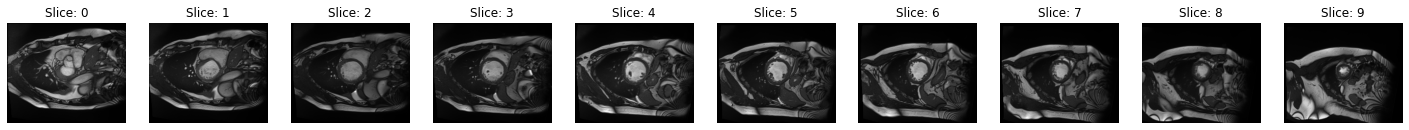

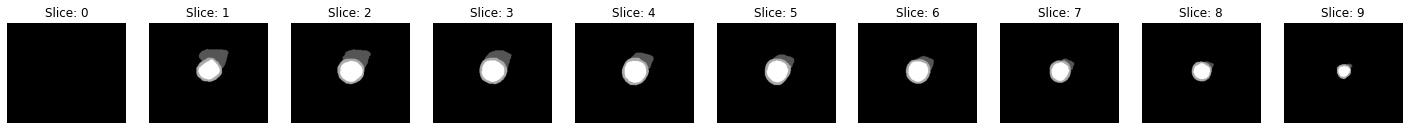

In [4]:
# Show images and masks
patient = 0
example_image = pre.heart_mask_loader( [ images_train_ED_path[patient] ] )
example_mask = pre.heart_mask_loader( [ masks_train_ED_path[patient] ] )
pre.visualize_image_mask(*example_image, *example_mask, example_image[0].shape[2])

Comparing the data of different patients, it can be observed that the relative position of the left and right ventricles varies. Therefore, in order to remove this source of variability, the 3D segmentation masks are rotated so that those structures are horizontally aligned, with the LV on the left and the RV on the right. This is done by the method ```align_heart_mask``` implemented on *preprocessing.py*. Essentially a line between the center of those two heart strutures is identified and its angle with the horizontal axis is computed, the image is then rotated by the negative of that value.

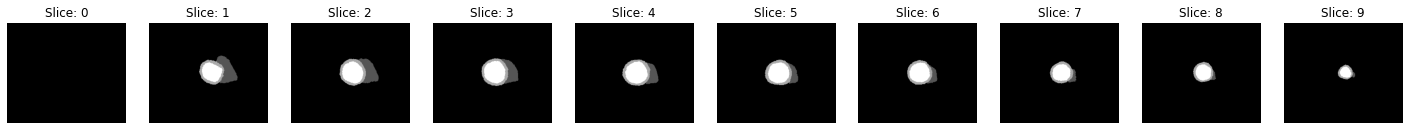

In [5]:
# Rotate masks so that the relative position of the LV and RV is always the same
example_mask = pre.align_heart_mask( example_mask )
pre.visualize_mask( *example_mask )

Also, the MRI scans include structures other than the LV, RV and MY, resulting in a large useless background area in the segmentation masks. Therefore the 3D segmentation masks are cropped to the smallest square containing the heart structures of interest, this is done by the method ```crop_heart_mask``` implemented on *preprocessing.py*.

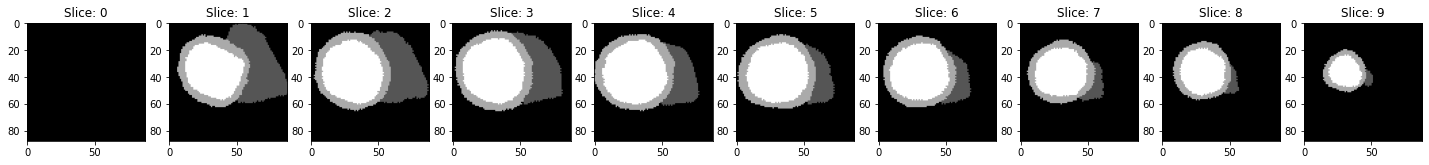

In [6]:
# Crops masks
example_mask = pre.crop_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

However, the cropping process results in segmentation masks of different sizes and the size of the input images of the VAE must be standardized. To solve this issue, the segmentation masks are either downsampled or upsampled using the nearest neighbour interpolation method so that each frame is of size $128 \times 128$, this is done by the method ```resize_heart_mask``` implemented on *preprocessing.py*.

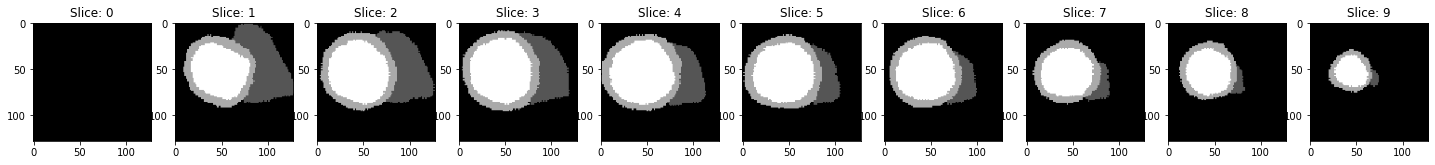

In [7]:
# Standardize image size (inputs of the network must be of same size)
example_mask = pre.resize_heart_mask(example_mask)
pre.visualize_mask( *example_mask, show_axis=True )

Once the 3D segmentation masks are aligned and cropped and their sizes standardized, their frames are decoupled (this is done by the method ```convert_3D_to_2D``` implemented on *preprocessing.py*.) and treated as independent 2D images. 

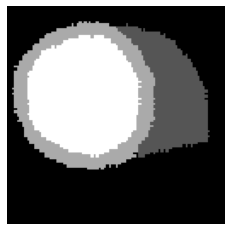

In [8]:
# Separate the frames, each frame will treated as a 2D image
example_mask = pre.convert_3D_to_2D(example_mask)

idx = 3
pre.visualize_2d_mask(example_mask[idx])

Up to this point, we have 2D segmentation masks with labels 0, 1, 2 and 3 corresponding to the background, RV, MY and LV, respectively, however we would like to have a one-hot encoding of the segmentation mask, i.e., one binary mask per channel. This transformation of the encoding is done by the method ```heart_mask_extraction``` inplemented on *preprocessing.py*.

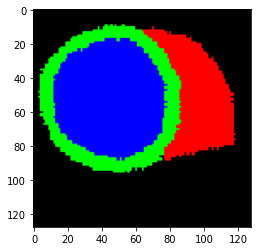

In [9]:
# Translate multilabel mask into multi channel mask (each channel represents a different structure),
# the axis are ordered according to PyTorch standard: (channel, height, width)
example_mask = pre.heart_mask_extraction(example_mask)
pre.visualize_multichannel_mask( example_mask[idx] )

All those pre-processing steps are combined on the method ```preprocessingPipeline```, implemented on *preprocessing.py*, that allows their efficient application to the entirety of the dataset. The resulting arrays are passed to a PyTorch DataLoader in order to be used to train and test the VAE.

In [10]:
train_data = pre.preprocessingPipeline( masks_train_ED_path ) 
test_data = pre.preprocessingPipeline( masks_test_ED_path )

In [11]:
# Saving the pre-processed dataset
pre.saveDataset(train_data, './', 'ED_train_data')
pre.saveDataset(test_data, './', 'ED_test_data')

In [12]:
# Loading the pre-processed dataset
train_data = pre.loadDataset('./', 'ED_train_data')
test_data = pre.loadDataset('./', 'ED_test_data')

## VAE

In [13]:
import torch
import model as m
import model_evaluation as eval

In [14]:
# if the .py is changed, run to reload
import importlib
importlib.reload(m)
importlib.reload(eval)

<module 'model_evaluation' from '/home/alice/GIT/Variational-Auto-Encoders-for-cardiac-shape-modeling/model_evaluation.py'>

In [15]:
# Decide in which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

# OBS
# I don't have a gpu so I couldn't test the code with device = torch.device("cuda:0")
# so there might be some errors to be fixed if you run the code in a computer with gpu.
# If you don't want to deal with them just uncomment the line bellow:

# device = "cpu"

In [16]:
batch_size = 64

# Define train, validation and test sets
train_set, val_set, test_set = torch.utils.data.random_split(np.concatenate([train_data, test_data], axis=0), [0.6, 0.2, 0.2])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [17]:
# Define the dimensions of the input space
n_channels = 4  
n_rows = n_cols = train_data[0].shape[-1]

# Create an instance of the VAE model
model = m.VAE(n_rows, n_cols, n_channels).to(device)

In [18]:
# Define the optimizer
learning_rate = 6e-5
l2 = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

In [19]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train_one_epoch(optimizer, train_loader, epoch=epoch, device=device)

Train Epoch: 0 [0/894 (0%)]	Loss: 0.014571
====> Epoch: 0 Average loss: 0.0130


In [23]:
# Visualize test set reconstruction
data = next(iter(train_loader))[:5]
eval.visualize( model, data, device=device )

In [21]:
# Save model so that we don't have to retrain every time
torch.save(model.state_dict(), './model.pt')

In [22]:
# Load saved model
model = m.VAE(n_rows, n_cols, n_channels).to(device)
model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>